In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import requests
import ast
import random

from skimage.morphology import label
from bs4 import BeautifulSoup
from z3 import *

In [2]:
def neighbours(i,j,N):
    return [[i+x,j+y] for (x,y) in [(-1,0),(0,-1),(1,0),(0,1)] if i+x>=0 and i+x <N and j+y>=0 and j+y <N ]

def pr(ans,fix,edge):
    n = fix.shape
    annot = fix.astype('str')
    annot[annot=="0"] =""
    fig,ax = plt.subplots(1,1,figsize=(n[0]/3,n[1]/3))
    ax =sns.heatmap(ans !=0,annot=annot,cbar=False,cmap="Greys_r",fmt="",linewidths=1,annot_kws={"size":14},linecolor='k')
    for (y,x,b,a) in edge:
        plt.arrow(x+0.5,y+0.5,a-x,b-y,color="r",head_width=0.25,head_length=0.25,length_includes_head=True,alpha=0.5)
    ax.axis("off")
    plt.show()

In [24]:
def sol(fix,tactic,force_connectivity=True,soln=[0]):
    start= time.time()
    N = fix.shape[0]
    print(N)
    C = int(np.sum(fix!=0))
    roots = [[i,j,e] for (i,j),e in np.ndenumerate(fix) if e !=0]
    
    s = Tactic(tactic).solver()   
    # Island Number
    X = np.array(IntVector('x', N**2),dtype=object).reshape(N,N)
    # order number in island tree
    Y = np.array(IntVector('y', N**2),dtype=object).reshape(N,N)

    if np.sum(soln)>0 :
        s += [X[i,j]==int(e) for (i,j),e in np.ndenumerate(soln)]
        solY =np.array([[ 1,  0,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                [ 2,  0,  5,  0,  0,  0,  0,  1,  0,  1,  0,  1,  2,  3,  4],
                [ 0,  0,  0,  0,  1,  2,  3,  0,  1,  0,  0,  0,  0,  0,  0],
                [ 0,  1,  2,  3,  0,  0,  0,  0,  0,  2,  1,  0,  1,  0,  1],
                [ 0,  0,  0,  0,  0,  1,  2,  0,  3,  4,  0,  1,  0,  0,  2],
                [ 0,  1,  2,  0,  1,  0,  0,  0,  0,  0,  0,  2,  3,  0,  0],
                [ 0,  0,  3,  0,  2,  0,  1,  0,  1,  2,  0,  0,  4,  0,  1],
                [ 0,  1,  0,  0,  3,  0,  2,  0,  0,  3,  4,  5,  0,  0,  0],
                [ 0,  2,  3,  0,  4,  5,  0,  1,  2,  0,  0,  0,  1,  2,  3],
                [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  2,  0,  0,  0],              
                [ 0,  1,  0,  0,  0,  1,  2,  3,  0,  1,  0,  0,  0,  1,  2],
                [ 0,  2,  3,  4,  0,  0,  0,  4,  0,  0,  0,  1,  2,  0,  3],
                [ 0,  0,  0,  5,  6,  7,  8,  0,  1,  2,  0,  0,  0,  0,  4], 
                [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  3,  2,  1,  0,  0],
                [ 0,  0,  1,  2,  3,  0,  1,  2,  3,  0,  4,  5,  6,  7,  8]])
        s += [Y[i,j]==int(e) for (i,j),e in np.ndenumerate(solY)]
   
    # limit the grid values to 0 (black) or the island
    s += [And(e>= 0 ,e <=C) for (i,j),e in np.ndenumerate(X)]
    s += [And(e>= 0 ,e <=int(np.max(fix))) for (i,j),e in np.ndenumerate(Y)]
    
        
    # set the island values for each root
    s += [X[a,b] == n+1 for n,[a,b,x] in enumerate(roots)]
    s += [Y[a,b] == int(x) for n,[a,b,x] in enumerate(roots)]
    
    # make sure the size of each island is correct
    s += [PbEq([(e==n+1,1) for (i,j),e in np.ndenumerate(X)],x) for n,[a,b,x] in enumerate(roots)]
    
    # no 2x2 black
    s += [Implies(e== 0,Or(X[i+1,j] !=0,X[i,j+1] !=0,X[i+1,j+1] !=0)) for (i,j),e in np.ndenumerate(X) if i<N-1 and j<N-1]  
    
    # islands don't touch
    s += [Implies(e > 0,And([Or(X[x,y]==e,X[x,y]==0) for x,y in neighbours(i,j,N)])) for (i,j),e in np.ndenumerate(X)]
   
    # Define a variable to determine if there is an edge between 2 cells
    edge = {}
    for i in range(N):
        for j in range(N):  
            for (k,l) in neighbours(i,j,N) :
                edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
                s += Or(edge[(i,j,k,l)] ==0,edge[(i,j,k,l)]==1) 
                
    for i in range(N):
        for j in range(N):  
            for (k,l) in neighbours(i,j,N):
                # Make edges one way to form a tree
                s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1
                # Cells with an edge have the same value
                s +=Implies(edge[(k,l,i,j)] == 1,X[i,j] == X[k,l])
    
    for i in range(N):
            for j in range(N):  
                # only one edge into each cell
                s += Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) <=1
                # root cells have no feeds in
                s += Implies(int(fix[i,j]) !=0, Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) == 0)
                # root cells > 1 feed out
                s += Implies(int(fix[i,j]) >1, Sum([edge[(i,j,k,l)] for (k,l) in neighbours(i,j,N) ]) >= 1)
                #filled cells have a feed in
                s+= Implies(X[i,j] !=0 , Or(Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N)]) == 1,int(fix[i,j]) !=0))
                # edges give decreasing numbers for islands
                s += [Implies(And(X[i,j]!=0,edge[(i,j,k,l)]==1),Y[i,j] > Y[k,l]) for (k,l) in neighbours(i,j,N)]
                #all cells are connected
                s += Implies(X[i,j]==0,Or([X[k,l]==0  for k,l in neighbours(i,j,N)]))
                # zero cells have a feed in or out
                s += Implies(X[i,j] == 0, Sum([edge[(i,j,k,l)]+edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) > 0 )
                
    # zero cells have island order zero
    s += [Implies(e==0,Y[i,j]==0) for (i,j),e in np.ndenumerate(X)]
    
    #s+= edge[(1,14,1,13)]==0
    
    if force_connectivity:
        # order number in sea
        Z = np.array(IntVector('z', N**2),dtype=object).reshape(N,N)
        #limit sea values
        s += [And(e>= 0 ,e <=int(N**2-np.sum(fix))) for (i,j),e in np.ndenumerate(Z)]
        # zero cells have sea order zero
        s += [Implies(e!=0,Z[i,j]==0) for (i,j),e in np.ndenumerate(X)]
        # edges give decreasing numbers for sea
        for i in range(N):
            for j in range(N):          
                s += [Implies(And(X[i,j]==0,edge[(i,j,k,l)]==1),Z[i,j] > Z[k,l]) for (k,l) in neighbours(i,j,N)]
        # only one river cell with no feed in => root
        s += PbEq([(And(X[i,j] == 0,Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) == 0),1) for i in range(N) for j in range(N)],1)
    
    while s.check() == sat:                
        m = s.model()
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        r =  evalu(X)
        y = evalu(Y)
        #print(r)
        #print(y)
        pr(r,fix,[i for i in edge if evalu(edge[i]) ==1])
        # check sea connectivity
        if np.max(label(r== 0,connectivity=1)) == 1:
            print("Connectivity OK")
            print("{}: {} Solved in {:.4f} seconds".format(tactic,tactic_description(tactic),time.time()-start))
            return r
        else:
            print("Connectivity FALSE")
            s += Or([e!=int(r[i,j]) for (i,j),e in np.ndenumerate(X) ])                     
    else:
        print("fail") 

15


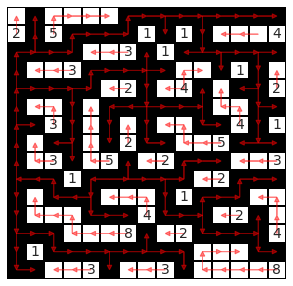

Connectivity OK
pqffd: builtin strategy for solving QF_FD problems in parallel. Solved in 2.9678 seconds


In [25]:
sols =np.array([[ 1,  0,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                [ 1,  0,  2,  0,  0,  0,  0,  3,  0,  4,  0,  5,  5,  5,  5],
                [ 0,  0,  0,  0,  6,  6,  6,  0,  7,  0,  0,  0,  0,  0,  0],
                [ 0,  8,  8,  8,  0,  0,  0,  0,  0, 11, 11,  0,  9,  0, 12],
                [ 0,  0,  0,  0,  0, 10, 10,  0, 11, 11,  0, 14,  0,  0, 12],
                [ 0, 13, 13,  0, 19,  0,  0,  0,  0,  0,  0, 14, 14,  0,  0],
                [ 0,  0, 13,  0, 19,  0, 16,  0, 17, 17,  0,  0, 14,  0, 15],
                [ 0, 18,  0,  0, 19,  0, 16,  0,  0, 17, 17, 17,  0,  0,  0],
                [ 0, 18, 18,  0, 19, 19,  0, 20, 20,  0,  0,  0, 21, 21, 21],
                [ 0,  0,  0, 22,  0,  0,  0,  0,  0,  0, 23, 23,  0,  0,  0],              
                [ 0, 27,  0,  0,  0, 25, 25, 25,  0, 24,  0,  0,  0, 29, 29],
                [ 0, 27, 27, 27,  0,  0,  0, 25,  0,  0,  0, 26, 26,  0, 29],
                [ 0,  0,  0, 27, 27, 27, 27,  0, 28, 28,  0,  0,  0,  0, 29], 
                [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0, 33, 33, 33,  0,  0],
                [ 0,  0,  31, 31, 31,  0, 32, 32, 32,  0, 33, 33, 33, 33, 33]])

ans = sol(to_solve,"pqffd",force_connectivity=True,soln=sols)


Random Pick is number 705


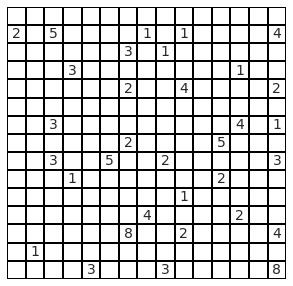

15


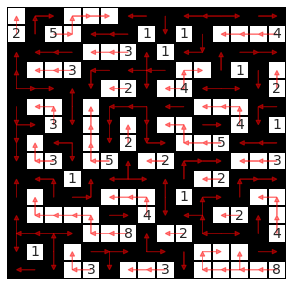

Connectivity FALSE


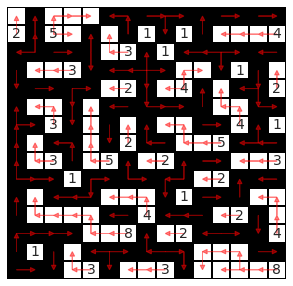

Connectivity FALSE


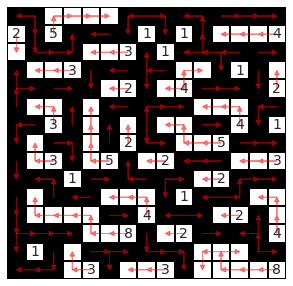

Connectivity FALSE


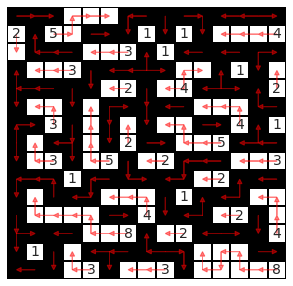

Connectivity FALSE


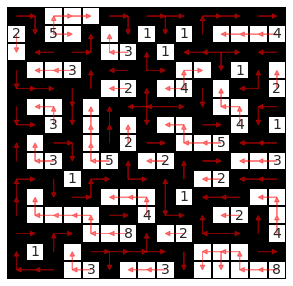

Connectivity FALSE


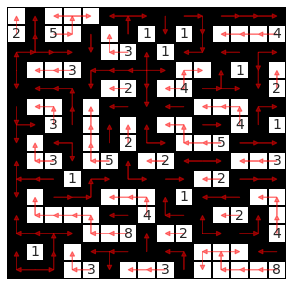

Connectivity FALSE


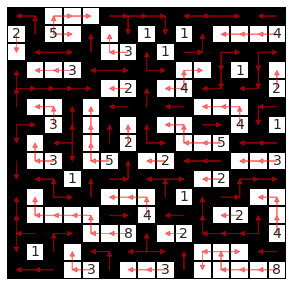

Connectivity FALSE


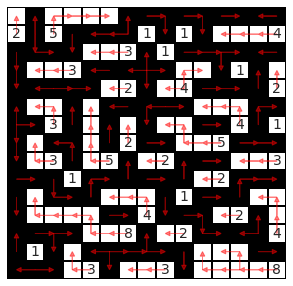

Connectivity FALSE


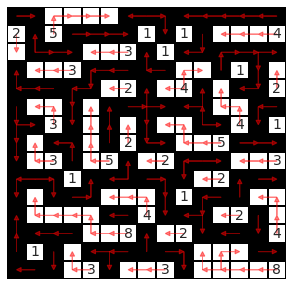

Connectivity FALSE


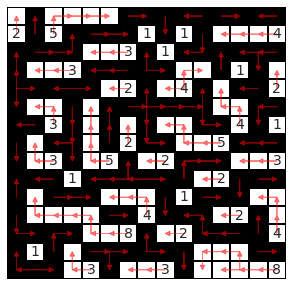

Connectivity FALSE


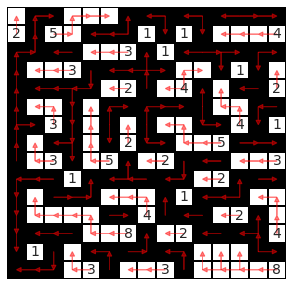

Connectivity FALSE


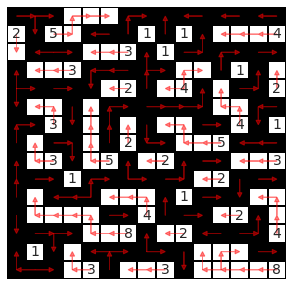

Connectivity FALSE
fail


In [21]:
# pick a random puzzle from ravenguild08's list
#valid sizes are 5,7,10,12,15,20

size = 15

url = 'https://raw.githubusercontent.com/ravenguild08/nrkb/master/'+str(size)+'x'+str(size)+'.json'
res = requests.get(url)
soup = str(BeautifulSoup(res.content, 'html.parser'))
puzzles = soup.split('\n')

x = random.randint(0,len(puzzles))
x = 705

to_solve = np.array(ast.literal_eval(puzzles[x]))
n = to_solve.shape

#plot the  grid to solve
print("Random Pick is number {}".format(x))
annot = to_solve.astype('str')
annot[annot=="0"] =""
fig,ax = plt.subplots(1,1,figsize=(n[0]/3,n[1]/3))
ax =sns.heatmap(np.zeros_like(to_solve),annot=annot,cbar=False,cmap="Greys",fmt="",linewidths=1,annot_kws={"size":14},linecolor='k')
ax.axis("off")
plt.show()


#then solve
ans = sol(to_solve,"pqffd",force_connectivity=False)

6


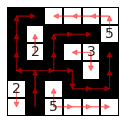

Connectivity OK
pqffd: builtin strategy for solving QF_FD problems in parallel. Solved in 0.4937 seconds


In [18]:
fix= np.array([[0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 5],
               [0, 2, 0, 0, 3, 0],
               [0, 0, 0, 0, 0, 0],
               [2, 0, 0, 0, 0, 0],
               [0, 0, 5, 0, 0, 0]])

ans1 = sol(fix,"pqffd")

10


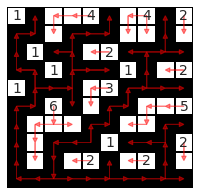

Connectivity OK
pqffd: builtin strategy for solving QF_FD problems in parallel. Solved in 1.5876 seconds


In [19]:
fix2= np.array([[1, 0, 0, 0, 4, 0, 0, 4, 0, 2],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 2, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 1, 0, 0, 2],
                [1, 0, 0, 0, 0, 3, 0, 0, 0, 0],
                [0, 0, 6, 0, 0, 0, 0, 0, 0, 5],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0, 0, 2],
                [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


ans2 = sol(fix2,"pqffd")

10


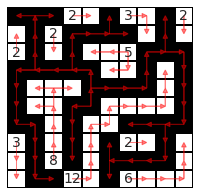

Connectivity OK
pqffd: builtin strategy for solving QF_FD problems in parallel. Solved in 3.8878 seconds


In [20]:
fix3=np.array([[0, 0, 0, 2, 0, 0, 3, 0, 0, 2],
               [0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
               [2, 0, 0, 0, 0, 0, 5, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [3, 0, 0, 0, 0, 0, 2, 0, 0, 0],
               [0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0,12, 0, 0, 6, 0, 0, 0]])

ans3 = sol(fix3,"pqffd")